<a href="https://colab.research.google.com/github/renanpyd/Course_Google_Colab/blob/main/site/en/tutorials/understanding/sngp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty-aware Deep Learning with SNGP

In AI applications that are safety-critical (e.g., medical decision making and autonomous driving) or where the data is inherently noisy (e.g., natural language understanding), it is important for a deep classifier to reliably quantify its uncertainty. The deep classifier should be able to be aware of its own limitations and when it should hand control over to the human experts. This tutorial shows how to improve a deep classifier's ability in quantifying uncertainty using a technique called **Spectral-normalized Neural Gaussian Process ([SNGP](https://arxiv.org/abs/2006.10108))**.

The core idea of SNGP is to improve a deep classifier's _**distance awareness**_ by applying simple modifications to the network. A model's _distance awareness_ is a measure of how its predictive probability reflects the distance between the test example and the training data. This is a desirable property that is common for gold-standard probablistic models (e.g., the [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) with RBF kernels) but is lacking in models with deep neural networks. SNGP provides a simple way to inject this Gaussian-process behavior into a deep classifier while maintaining its predictive accuracy.

This tutorial implements a deep residual network (ResNet)-based SNGP model on the [two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset, and compares its uncertainty surface with that of two other popular uncertainty approaches - [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474)).

This tutorial illustrates the SNGP model on a toy 2D dataset. For an example of applying SNGP to a real-world natural language understanding task using  BERT-base, please see the [SNGP-BERT tutorial](https://www.tensorflow.org/official_models/tutorials/uncertainty_quantification_with_sngp_bert). For high-quality implementations of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc), please check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## About SNGP

[Spectral-normalized Neural Gaussian Process](https://arxiv.org/abs/2006.10108)  (SNGP) is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

* It applies spectral normalization to the hidden residual layers.
* It replaces the Dense output layer with a Gaussian process layer.

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Compared to other uncertainty approaches (e.g., Monte Carlo dropout or Deep ensemble), SNGP has several advantages:

* It works for a wide range of state-of-the-art residual-based architectures (e.g., (Wide) ResNet, DenseNet, BERT, etc).
* It is a single-model method (i.e., does not rely on ensemble averaging). Therefore SNGP has a similar level of latency as a single deterministic network, and can be scaled easily to large datasets like [ImageNet](https://github.com/google/uncertainty-baselines/tree/main/baselines/imagenet) and [Jigsaw Toxic Comments classification](https://github.com/google/uncertainty-baselines/tree/main/baselines/toxic_comments).
* It has strong out-of-domain detection performance due to the _distance-awareness_ property.

The downsides of this method are:

* The predictive uncertainty of a SNGP is computed using the [Laplace approximation](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf). Therefore theoretically, the posterior uncertainty of SNGP is different from that of an exact Gaussian process.

* SNGP training needs a covariance reset step at the begining of a new epoch. This can add a tiny amount of extra complexity to a training pipeline. This tutorial shows a simple way to implement this using Keras callbacks.

## Setup

In [1]:
!pip install --use-deprecated=legacy-resolver tf-models-official

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 352 kB 48.9 MB/s 
     |████████████████████████████████| 1.2 MB 32.7 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
     |████████████████████████████████| 99 kB 7.2 MB/s 
     |████████████████████████████████| 4.9 MB 22.3 MB/s 
     |████████████████████████████████| 47.7 MB 116 kB/s 
     |████████████████████████████████| 213 kB 46.8 MB/s 
     |████████████████████████████████| 90 kB 5.5 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 18.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=6c09f118c3471a2b1b943874b5d9b62209a2c128b10d23a05394161aee8e7713
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b6c3218cef06547fe

In [2]:
# refresh pkg_resources so it takes the changes into account.
import pkg_resources
import importlib
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

Define visualization macros

In [4]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the trainining and evaluation datasets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [5]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [6]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training.

In [7]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

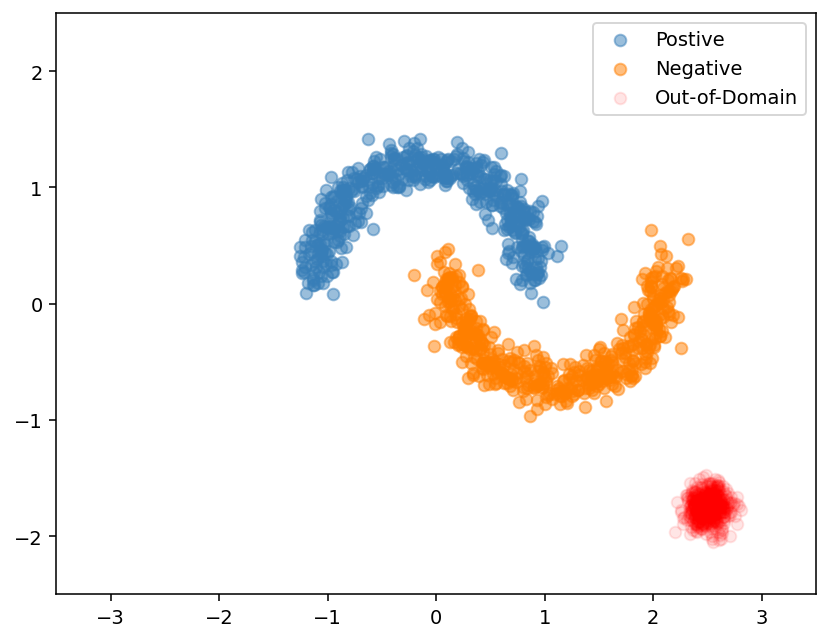

In [8]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Here the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## The deterministic model

### Define model

Start from the (baseline) deterministic model: a multi-layer residual network (ResNet) with dropout regularization.

In [9]:
#@title
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the resnet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

This tutorial uses a 6-layer ResNet with 128 hidden units.

In [10]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)

In [11]:
resnet_model = DeepResNet(**resnet_config)

In [12]:
resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  384       
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  16512     
                                                                 
 dense_3 (Dense)             multiple                  16512     
                                                                 
 dense_4 (Dense)             multiple                  16512     
                                                                 
 dense_5 (Dense)             multiple                  16512     
                                                                 
 dense_6 (Dense)             multiple                 

### Train model

Configure the training parameters to use `SparseCategoricalCrossentropy` as the loss function and the Adam optimizer.

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

Train the model for 100 epochs with batch size 128.

In [14]:
fit_config = dict(batch_size=128, epochs=100)

In [15]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 1s 8ms/step - loss: 0.4850 - sparse_categorical_accuracy: 0.7860
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.2669 - sparse_categorical_accuracy: 0.9050
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1900 - sparse_categorical_accuracy: 0.9200
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1567 - sparse_categorical_accuracy: 0.9330
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9400
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9440
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1204 - sparse_categorical_accuracy: 0.9490
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9420
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - lo

### Visualize uncertainty

In [16]:
#@title
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

Now visualize the predictions of the deterministic model. First plot the class probability: 
$$p(x) = softmax(logit(x))$$

In [17]:
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

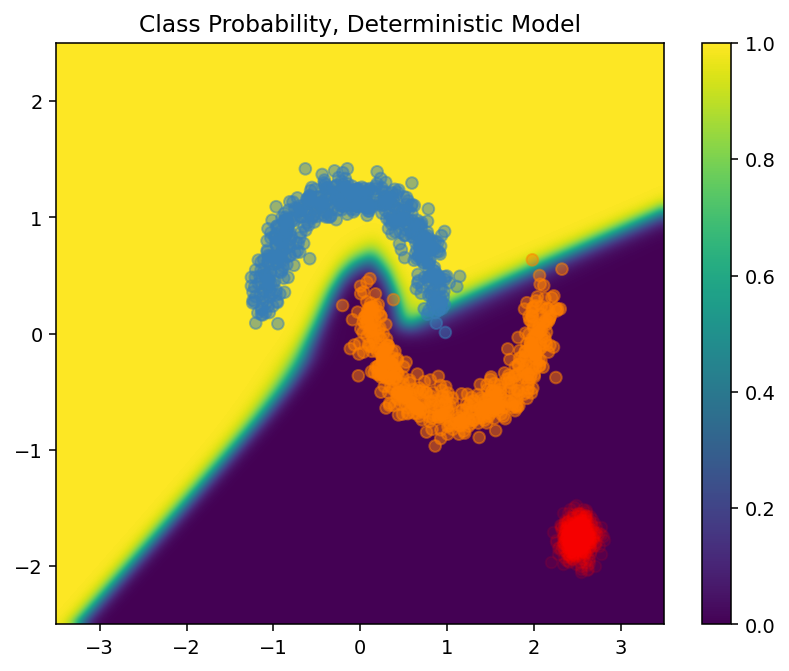

In [18]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In this plot, the yellow and purple are the predictive probabilities for the two classes. The deterministic model did a good job in classifying the two known classes (blue and orange) with a nonlinear decision boundary. However, it is not **distance-aware**, and classified the never-seen red out-of-domain (OOD) examples confidently as the orange class.

Visualize the model uncertainty by computing the [predictive variance](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance):
$$var(x) = p(x) * (1 - p(x))$$

In [19]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

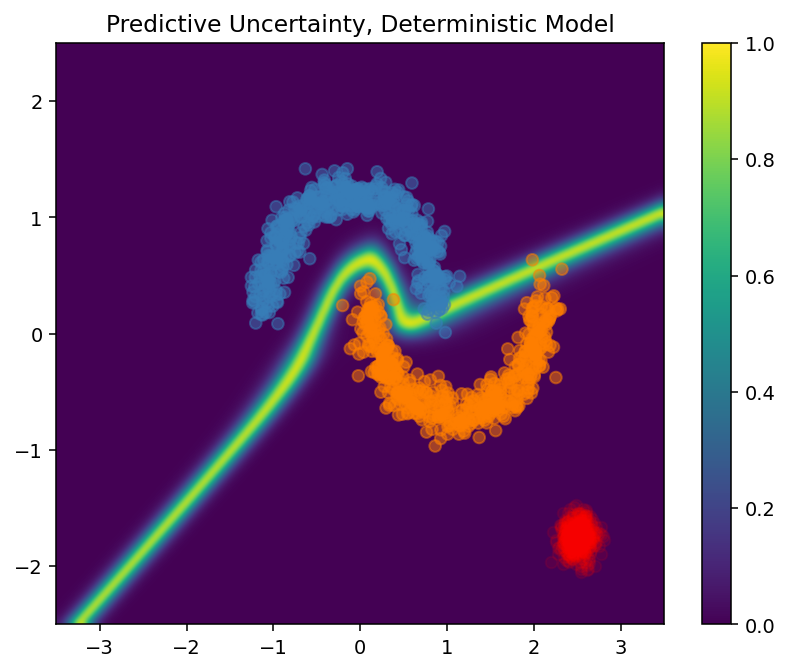

In [20]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

In this plot, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

### Define SNGP model

Let's now implement the SNGP model. Both the SNGP components, `SpectralNormalization` and `RandomFeatureGaussianProcess`, are available at the tensorflow_model's [built-in  layers](https://github.com/tensorflow/models/tree/master/official/nlp/modeling/layers). 

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Let's look at these two components in more detail. (You can also jump to the [The SNGP model](#full-sngp-model) section to see how the full model is implemented.)

#### Spectral Normalization wrapper

[`SpectralNormalization`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/spectral_normalization.py) is a Keras layer wrapper. It can be applied to an existing Dense layer like this:

In [21]:
dense = tf.keras.layers.Dense(units=10)
dense = nlp_layers.SpectralNormalization(dense, norm_multiplier=0.9)

Spectral normalization regularizes the hidden weight $W$ by gradually guiding its spectral norm (i.e., the largest eigenvalue of $W$) toward the target value  `norm_multiplier`. 


Note: Usually it is preferable to set `norm_multiplier` to a value smaller than 1. However in practice, it can be also relaxed to a larger value to ensure the deep network has enough expressive power.

#### The Gaussian Process (GP) layer

[`RandomFeatureGaussianProcess`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/gaussian_process.py) implements a [random-feature based approximation](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) to a Gaussian process model that is end-to-end trainable with a deep neural network. Under the hood, the Gaussian process layer implements a two-layer network:

$$logits(x) = \Phi(x) \beta, \quad \Phi(x)=\sqrt{\frac{2}{M}} * cos(Wx + b)$$

Here $x$ is the input, and $W$ and $b$ are frozen weights initialized randomly from Gaussian and uniform distributions, respectively. (Therefore $\Phi(x)$ are called "random features".) $\beta$ is the learnable kernel weight similar to that of a Dense layer. 

In [22]:
batch_size = 32
input_dim = 1024
num_classes = 10

In [23]:
gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
                                               num_inducing=1024,
                                               normalize_input=False,
                                               scale_random_features=True,
                                               gp_cov_momentum=-1)

The main parameters of the GP layers are:

* `units`: The dimension of the output logits.
* `num_inducing`: The dimension $M$ of the hidden weight $W$. Default to 1024.
* `normalize_input`: Whether to apply layer normalization to the input $x$.
* `scale_random_features`: Whether to apply the scale $\sqrt{2/M}$ to the hidden output.


Note: For a deep neural network that is sensitive to the learning rate (e.g., ResNet-50 and ResNet-110), it is generally recommended to set `normalize_input=True` to stablize training, and set `scale_random_features=False` to avoid the learning rate from being modified in unexpected ways when passing through the GP layer.

* `gp_cov_momentum` controls how the model covariance is computed. If set to a positive value (e.g., 0.999), the covariance matrix is computed using the momentum-based moving average update (similar to batch normalization). If set to -1, the the covariance matrix is updated without momentum.

Note: The momentum-based update method can be sensitive to batch size. Therefore it is generally recommended to set  `gp_cov_momentum=-1` to compute the covariance exactly. For this to work properly, the covariance matrix estimator needs to be reset at the begining of a new epoch in order to avoid counting the same data twice. For `RandomFeatureGaussianProcess`, this is can be done by calling its `reset_covariance_matrix()`. The next section shows an easy implementation of this using Keras' built-in API.


Given a batch input with shape `(batch_size, input_dim)`, the GP layer returns a `logits` tensor (shape `(batch_size, num_classes)`) for prediction, and also  `covmat` tensor (shape `(batch_size, batch_size)`) which is the posterior covariance matrix of the batch logits.

In [24]:
embedding = tf.random.normal(shape=(batch_size, input_dim))

logits, covmat = gp_layer(embedding)

Note: Notice that under this implementation of the SNGP model, the predictive logits $logit(x_{test})$ for all classes share the same covariance matrix $var(x_{test})$, which describes the distance between $x_{test}$ from the training data. 

Theoretically, it is possible to extend the algorithm to compute different variance values for different classes (as introduced in the [original SNGP paper](https://arxiv.org/abs/2006.10108)). However, this is difficult to scale to problems with large output spaces (e.g., ImageNet or language modeling).

<a name="full-sngp-model"></a>
#### The full SNGP model

Given the base class `DeepResNet`, the SNGP model can be implemented easily by  modifying the residual network's hidden and output layers. For compatibility with Keras `model.fit()` API, also modify the model's `call()` method so it only outputs `logits` during training.

In [25]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes, 
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and covariance matrix from GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

Use the same architecture as the deterministic model.

In [26]:
resnet_config

{'num_classes': 2, 'num_hidden': 128, 'num_layers': 6}

In [27]:
sngp_model = DeepResNetSNGP(**resnet_config)

In [28]:
sngp_model.build((None, 2))
sngp_model.summary()

Model: "deep_res_net_sngp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  384       
                                                                 
 spectral_normalization_1 (S  multiple                 16768     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_2 (S  multiple                 16768     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_3 (S  multiple                 16768     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_4 (S  multiple                 16768     
 pectralNormalization)                           

<a name="covariance-reset-callback"></a>
Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [29]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

Add this callback to the `DeepResNetSNGP` model class.

In [30]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

### Train model

Use `tf.keras.model.fit` to train the model.

In [31]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 5s 37ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.9670
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.9970
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.4778 - sparse_categorical_accuracy: 1.0000
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 0.4359 - sparse_categorical_accuracy: 1.0000
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.9990
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3729 - sparse_categorical_accuracy: 0.9990
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3486 - sparse_categorical_accuracy: 0.9980
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 0.3279 - sparse_categorical_accuracy: 0.9970
Epoch 9/100
8/8 [==============================] - 0s 33ms/step 

### Visualize uncertainty

First compute the predictive logits and  variances.

In [32]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)

In [33]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

<a name="mean-field-logits"></a>
Now compute the posterior predictive probability. The classic method for computing the predictive probability of a probabilistic model is to use Monte Carlo sampling, i.e.,

$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M logit_m(x), $$

where $M$ is the sample size, and $logit_m(x)$ are random samples from the SNGP posterior $MultivariateNormal$(`sngp_logits`,`sngp_covmat`). However, this approach can be slow for latency-sensitive applications such as autonomous driving or real-time bidding. Instead, can approximate $E(p(x))$ using the [mean-field method](https://arxiv.org/abs/2006.07584):

$$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is often chosen as $\pi/8$ or $3/\pi^2$.

In [34]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

Note: Instead of fixing $\lambda$ to a fixed value, you can also treat it as a hyperparameter, and tune it to optimize the model's calibration performance. This is known as [temperature scaling](http://proceedings.mlr.press/v70/guo17a.html) in the deep learning uncertainty literature. 

This mean-field method is implemented as a built-in function `layers.gaussian_process.mean_field_logits`:

In [35]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  
  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [36]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

### SNGP Summary

In [37]:
#@title

def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()  

Put everything together. The entire procedure (training, evaluation and uncertainty computation) can be done in just five lines:

In [38]:
def train_and_test_sngp(train_examples, test_examples):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [39]:
sngp_probs = train_and_test_sngp(train_examples, test_examples)

Visualize the class probability (left) and the predictive uncertainty (right) of the SNGP model.

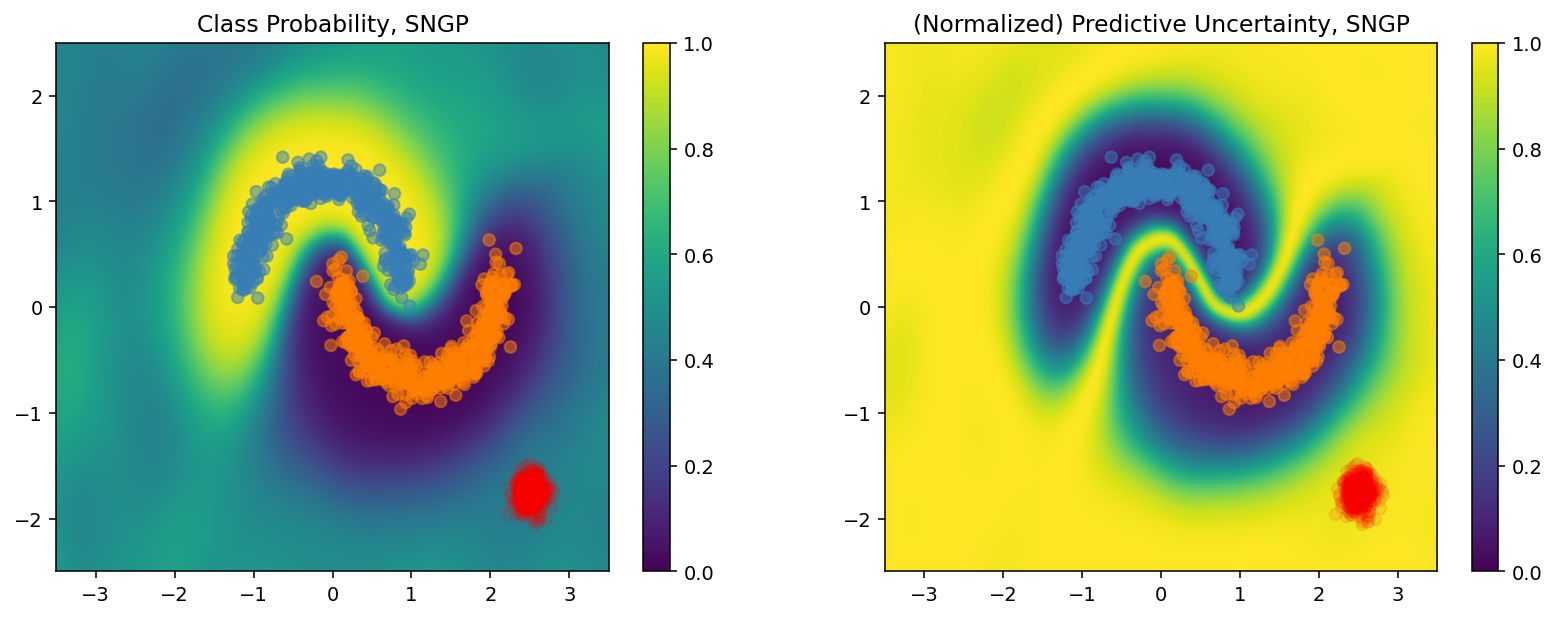

In [40]:
plot_predictions(sngp_probs, model_name="SNGP")

Remember that in the class probability plot (left), the yellow and purple are class probabilities. When close to the training data domain, SNGP correctly classifies the examples with high confidence (i.e., assigning near 0 or 1 probability). When far away from the training data, SNGP gradually becomes less confident, and its predictive probability becomes close to 0.5 while the (normalized) model uncertainty rises to 1.

Compare this to the uncertainty surface of the deterministic model: 

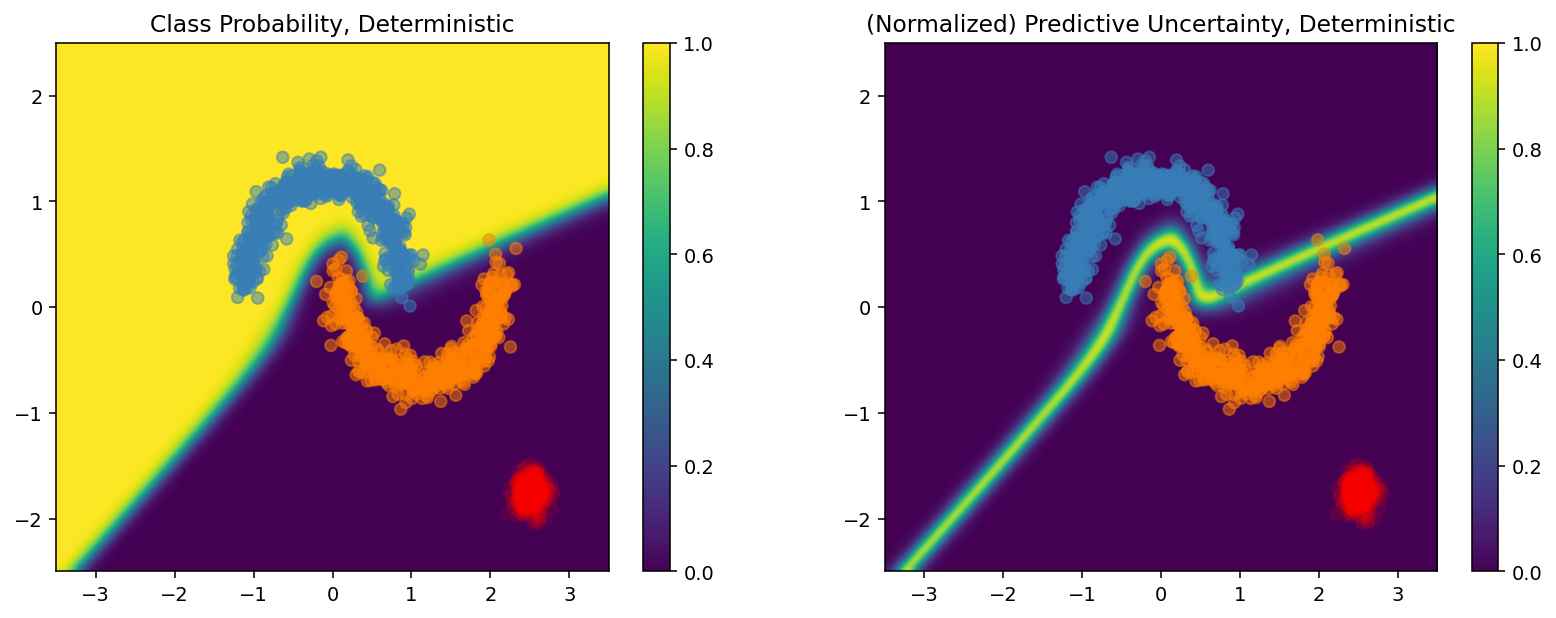

In [41]:
plot_predictions(resnet_probs, model_name="Deterministic")

Like mentioned earlier, a deterministic model is not _distance-aware_. Its uncertainty is defined by the distance of the test example from the decision boundary. This leads the model to produce overconfident predictions for the out-of-domain examples (red).

## Comparison with other uncertainty approaches

This section compares the uncertainty of SNGP with [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474).

Both of these methods are based on Monte Carlo averaging of multiple forward passes of deterministic models. First set the ensemble size $M$.

In [42]:
num_ensemble = 10

### Monte Carlo dropout

Given a trained neural network with Dropout layers, [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) computes the mean predictive probability 

$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$$ 

by averaging over multiple Dropout-enabled forward passes $\{logit_m(x)\}_{m=1}^M$.

In [43]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [44]:
# Monte Carlo dropout inference.
dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [45]:
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

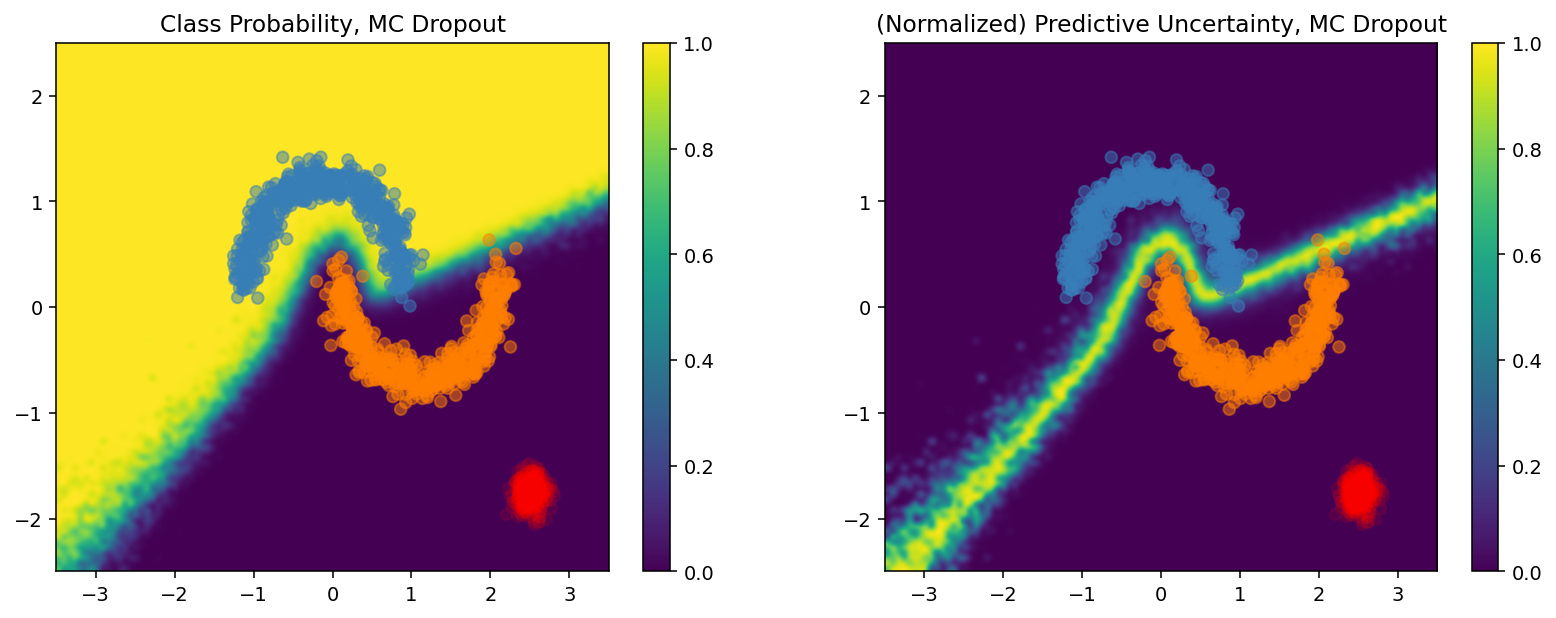

In [46]:
plot_predictions(dropout_probs, model_name="MC Dropout")

### Deep ensemble

[Deep ensemble](https://arxiv.org/abs/1612.01474) is a state-of-the-art (but expensive) method for deep learning uncertainty. To train a Deep ensemble, first train $M$ ensemble members.

In [47]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)  

  resnet_ensemble.append(resnet_model)

Collect logits and compute the mean predctive probability $E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$.

In [48]:
# Deep ensemble inference
ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

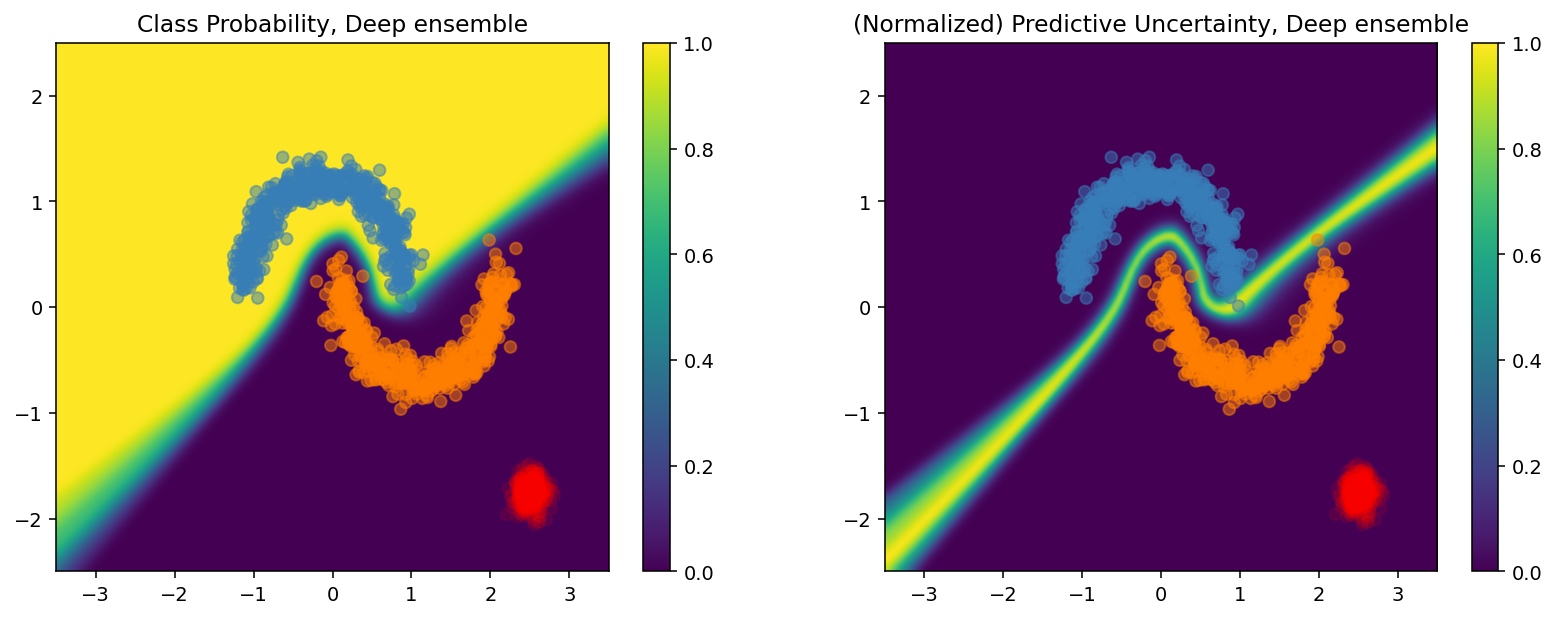

In [49]:
plot_predictions(ensemble_probs, model_name="Deep ensemble")

Both MC Dropout and Deep ensemble improve a model's uncertainty ability by making the decision boundary less certain. However, they both inherit the deterministic deep network's limitation in lacking distance awareness.

## Summary

In this tutorial, you have:
* Implemented a SNGP model on a deep classifier to improve its distance awareness.
* Trained the SNGP model end-to-end using Keras `model.fit()` API.
* Visualized the uncertainty behavior of SNGP.
* Compared the uncertainty behavior between SNGP, Monte Carlo dropout and deep ensemble models.

## Resources and further reading

* See the [SNGP-BERT tutorial](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert) for an example of applying SNGP on a BERT model for uncertainty-aware natural language understanding.
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).
